<a href="https://colab.research.google.com/github/HakureiPOI/CIFAR-10-wyx/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Display the shapes of the loaded data
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [2]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("CIFAR-10 类别名称:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

CIFAR-10 类别名称:
  0: airplane
  1: automobile
  2: bird
  3: cat
  4: deer
  5: dog
  6: frog
  7: horse
  8: ship
  9: truck


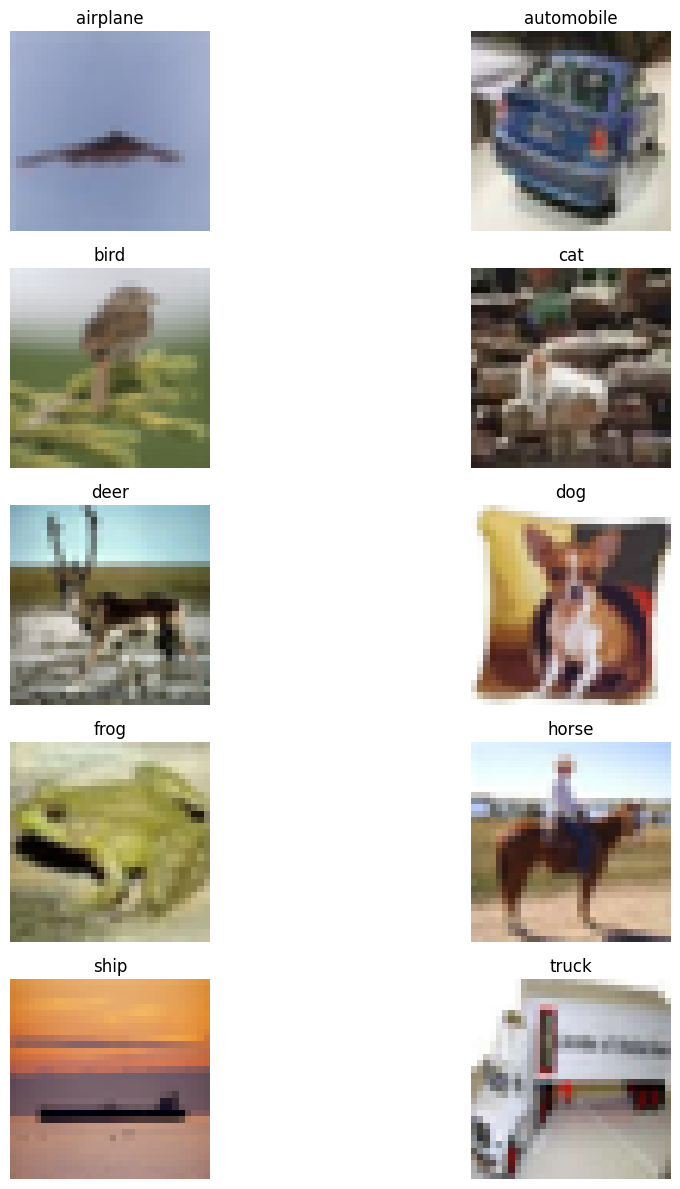

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming class_names, x_train, and y_train are already defined from previous cells

plt.figure(figsize=(12, 12))
for i in range(len(class_names)):
    # Get all images belonging to the current class
    class_indices = np.where(y_train == i)[0]
    # Randomly select one image index from this class
    idx = np.random.choice(class_indices)

    plt.subplot(5, 2, i + 1) # Create a 5x2 grid for 10 classes
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf

def preprocess_image(image, label):
    # Convert image to tf.float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random Gaussian blur
    # Apply blur with a probability (e.g., 50% chance)
    if tf.random.uniform(()) > 0.5:
        # Gaussian blur kernel (example, can be made more sophisticated)
        # For simplicity, using a small, fixed kernel size and sigma.
        # For more control, one might use tf.nn.conv2d with a Gaussian kernel.
        # Or, for newer TensorFlow versions, tf.image.gaussian_filter2d
        kernel_size = 3
        sigma = tf.random.uniform(shape=[], minval=0.5, maxval=1.5) # Random sigma

        # Create a 2D Gaussian kernel
        # Adapted from: https://stackoverflow.com/questions/59695679/tensorflow-gaussian-blur-on-image
        def get_gaussian_kernel(kernel_size, sigma, n_channels):
            x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
            x = tf.exp(-(x**2 / (2. * sigma**2)))
            x = x / tf.reduce_sum(x)
            # Corrected: Use tf.einsum for outer product as tf.outer might not be directly available
            kernel = tf.einsum('i,j->ij', x, x)
            kernel = tf.expand_dims(tf.expand_dims(kernel, -1), -1)
            kernel = tf.repeat(kernel, n_channels, axis=2)
            return kernel

        kernel = get_gaussian_kernel(kernel_size, sigma, tf.shape(image)[-1])
        image = tf.nn.depthwise_conv2d(tf.expand_dims(image, 0), kernel, strides=[1, 1, 1, 1], padding='SAME')[0]

    return image, label

print("数据预处理函数已定义：preprocess_image")

数据预处理函数已定义：preprocess_image


In [5]:
BATCH_SIZE = 32

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply preprocessing function to the datasets
# Use num_parallel_calls for faster processing
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("数据预处理和数据集创建完成。")
print(f"训练数据集元素类型: {train_ds.element_spec}")
print(f"测试数据集元素类型: {test_ds.element_spec}")

数据预处理和数据集创建完成。
训练数据集元素类型: (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))
测试数据集元素类型: (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))


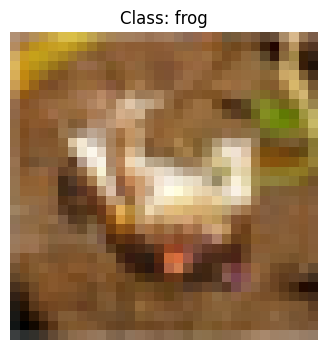

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    # Select the first image and label from the batch
    sample_image = images[0].numpy()  # Convert TensorFlow tensor to NumPy array
    sample_label_index = labels[0].numpy()[0] # Extract the scalar label index

    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(sample_image)
    plt.title(f"Class: {class_names[sample_label_index]}")
    plt.axis('off')
    plt.show()
    break # Only take one batch and display one image


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# 1. 定义残差块 (Residual Block)
# 这是一个基本的ResNet块，包含两个卷积层、批标准化和ReLU激活。
# 如果输入和输出维度不匹配，shortcut路径会使用1x1卷积进行调整。
def residual_block(x, filters, kernel_size=3, stride=1, activation='relu', use_bias=False):
    # 主路径
    y = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=use_bias)(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)

    y = layers.Conv2D(filters, kernel_size, padding='same', use_bias=use_bias)(y)
    y = layers.BatchNormalization()(y)

    # shortcut路径
    # 如果步长不为1或通道数不匹配，需要通过1x1卷积调整shortcut路径的维度
    if stride != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, strides=stride, use_bias=use_bias)(x)
        x = layers.BatchNormalization()(x)

    # 将主路径和shortcut路径的输出相加
    out = layers.add([x, y])
    out = layers.Activation(activation)(out)
    return out

# 2. 构建针对CIFAR-10的ResNet18风格模型
# 该模型针对32x32的CIFAR-10图像进行了调整，移除了原始ResNet中的激进的初始下采样层。
def build_resnet18_cifar10(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)

    # 初始卷积层 (为CIFAR-10调整)
    # 使用较小的3x3内核和步长1，避免过早大幅度减小特征图尺寸
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ResNet阶段
    # 阶段1: 2个残差块，64个滤波器
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # 阶段2: 2个残差块，128个滤波器，第一个块步长为2进行下采样
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    # 阶段3: 2个残差块，256个滤波器，第一个块步长为2进行下采样
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    # 阶段4: 2个残差块，512个滤波器，第一个块步长为2进行下采样
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # 最终层
    x = layers.GlobalAveragePooling2D()(x) # 将空间维度缩小到1x1
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x)
    return model

# 获取输入形状和类别数量 (已在前面单元格中定义)
input_shape = x_train.shape[1:]  # (32, 32, 3)
num_classes = len(class_names) # 10

# 实例化模型
resnet_model = build_resnet18_cifar10(input_shape=input_shape, num_classes=num_classes)

print("ResNet-like 模型架构概述:")
resnet_model.summary()

ResNet-like 模型架构概述:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ activation[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ activation_2[0][

 Total params: 11,183,562 (42.66 MB)

 Trainable params: 11,173,962 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [8]:
# 3. 编译模型
# 使用Adam优化器，损失函数选择'sparse_categorical_crossentropy'因为标签是整数形式。
resnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# 4. 训练模型
EPOCHS = 10 # 可以根据需要调整训练轮数

print(f"\n开始训练 {EPOCHS} 个周期...")
history = resnet_model.fit(train_ds,
                           epochs=EPOCHS,
                           validation_data=test_ds)

print("\n模型训练完成。")


开始训练 10 个周期...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 108s 56ms/step - accuracy: 0.3577 - loss: 1.8116 - val_accuracy: 0.4370 - val_loss: 1.6528
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.5745 - loss: 1.1872 - val_accuracy: 0.4569 - val_loss: 1.6353
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.6487 - loss: 0.9800 - val_accuracy: 0.6488 - val_loss: 0.9935
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.7050 - loss: 0.8369 - val_accuracy: 0.6745 - val_loss: 0.9342
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.7417 - loss: 0.7320 - val_accuracy: 0.7017 - val_loss: 0.8754
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.7748 - loss: 0.6441 - val_accuracy: 0.6963 - val_loss: 0.8885
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.8003 - loss: 0.5707 - val_accuracy: 0.7591 - val_loss: 0.7177
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - a